In [1]:
import torch
from torchvision import transforms as T

In [3]:
from maskrcnn_benchmark.config import cfg
from maskrcnn_benchmark.modeling.detector.generalized_rcnn import GeneralizedRCNN
from maskrcnn_benchmark.utils.checkpoint import Checkpointer
from maskrcnn_benchmark.data.collate_batch import BatchCollator
# from demo.predictor import Resize
from maskrcnn_benchmark.structures.image_list import to_image_list

In [4]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CPU_DEVICE = torch.device('cpu')
# DEVICE = CPU_DEVICE

assert torch.cuda.device_count() <= 1   # cluster rules.

DEVICE

device(type='cuda')

In [5]:
cfg.merge_from_file('configs/rcnn/pretrained_vg_cfg.yaml')
cfg.freeze()

In [6]:
grcnn = GeneralizedRCNN(cfg)

In [7]:
# checkpointer = SceneParserCheckpointer(cfg, model, optimizer, scheduler, save_dir, save_to_disk,
# extra_checkpoint_data = checkpointer.load(cfg.MODEL.WEIGHT, resume=cfg.resume)
checkpointer = Checkpointer(grcnn)
grcnn = grcnn.to(DEVICE)

In [8]:
# load model, currently not using ['optimizer', 'scheduler', 'iteration']
_ = checkpointer.load(cfg.MODEL.WEIGHT)

In [16]:
# Copyright (c) Facebook, Inc. and its affiliates. All Rights Reserved.


def build_transform(cfg):
    """
    Creates a basic transformation that was used to train the models
    """
    # we are loading images with OpenCV, so we don't need to convert them
    # to BGR, they are already! So all we need to do is to normalize
    # by 255 if we want to convert to BGR255 format, or flip the channels
    # if we want it to be in RGB in [0-1] range.
    if cfg.INPUT.TO_BGR255:
        to_bgr_transform = T.Lambda(lambda x: x * 255)
    else:
        to_bgr_transform = T.Lambda(lambda x: x[[2, 1, 0]])

    normalize_transform = T.Normalize(mean=cfg.INPUT.PIXEL_MEAN,
                                      std=cfg.INPUT.PIXEL_STD)
    min_size = cfg.INPUT.MIN_SIZE_TEST
    max_size = cfg.INPUT.MAX_SIZE_TEST
    transform = T.Compose([
        T.ToPILImage(),
        # Resize(min_size, max_size),
        T.ToTensor(),
        to_bgr_transform,
        normalize_transform,
    ])
    return transform


transforms = build_transform(cfg)

In [17]:
import cv2

original_image = cv2.imread(
    '/mnt/nas2/GrimaRepo/datasets/visual_genome/VG_100K_2/2404936.jpg')

In [18]:
# from demo.predictor

grcnn.eval()

image = transforms(original_image)
# convert to an ImageList, padded so that it is divisible by
# cfg.DATALOADER.SIZE_DIVISIBILITY
image_list = to_image_list(image)
image_list = image_list.to(DEVICE)
# compute predictions
with torch.no_grad():
    predictions = grcnn(image_list)
predictions = [o.to(CPU_DEVICE) for o in predictions]

# always single image is passed at a time
prediction = predictions[0]

# reshape prediction (a BoxList) into the original image size
height, width = original_image.shape[:-1]
prediction = prediction.resize((width, height))

In [19]:
# Copyright (c) Facebook, Inc. and its affiliates. All Rights Reserved.


def compute_colors_for_labels(labels):
    """
    Simple function that adds fixed colors depending on the class
    """
    colors = labels[:, None] * torch.tensor([2**25 - 1, 2**15 - 1, 2**21 - 1])
    colors = (colors % 255).numpy().astype("uint8")
    return colors


def overlay_boxes(image, predictions):
    """
    Adds the predicted boxes on top of the image

    Arguments:
        image (np.ndarray): an image as returned by OpenCV
        predictions (BoxList): the result of the computation by the model.
            It should contain the field `labels`.
    """
    labels = predictions.get_field("labels")
    boxes = predictions.bbox

    colors = compute_colors_for_labels(labels).tolist()

    for box, color in zip(boxes, colors):
        box = box.to(torch.int64)
        top_left, bottom_right = box[:2].tolist(), box[2:].tolist()
        image = cv2.rectangle(image, tuple(top_left), tuple(bottom_right),
                              tuple(color), 1)

    return image


def overlay_class_names(image, predictions):
    """
    Adds detected class names and scores in the positions defined by the
    top-left corner of the predicted bounding box

    Arguments:
        image (np.ndarray): an image as returned by OpenCV
        predictions (BoxList): the result of the computation by the model.
            It should contain the field `scores` and `labels`.
    """
    scores = predictions.get_field("scores").tolist()
    labels = predictions.get_field("labels").tolist()
    labels = [CATEGORIES[i] for i in labels]
    boxes = predictions.bbox

    template = "{}: {:.2f}"
    for box, score, label in zip(boxes, scores, labels):
        x, y = box[:2]
        s = template.format(label, score)
        cv2.putText(image, s, (x, y), cv2.FONT_HERSHEY_SIMPLEX, .5,
                    (255, 255, 255), 1)

    return


def select_top_predictions(predictions, threshold=0.3):
    """
    Select only predictions which have a `score` > self.confidence_threshold,
    and returns the predictions in descending order of score

    Arguments:
        predictions (BoxList): the result of the computation by the model.
            It should contain the field `scores`.

    Returns:
        prediction (BoxList): the detected objects. Additional information
            of the detection properties can be found in the fields of
            the BoxList via `prediction.fields()`
    """
    scores = predictions.get_field("scores")
    keep = torch.nonzero(scores > threshold).squeeze(1)
    predictions = predictions[keep]
    scores = predictions.get_field("scores")
    _, idx = scores.sort(0, descending=True)
    return predictions[idx]

In [20]:
top_predictions = select_top_predictions(prediction)

result = original_image
result = overlay_boxes(result, top_predictions)

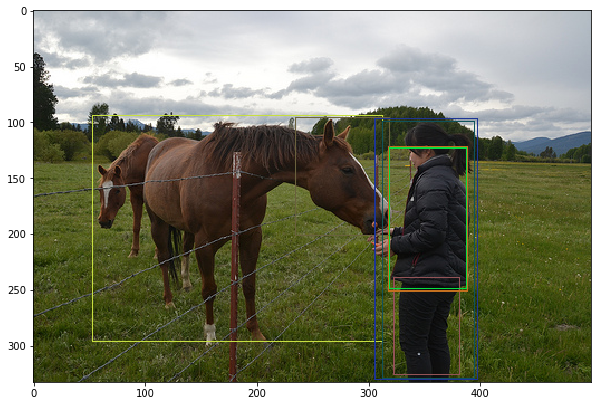

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt

fig2 = plt.figure(figsize = (10,10)) # create a 5 x 5 figure 
ax3 = fig2.add_subplot(111)
ax3.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB), interpolation='none')

plt.show()